In [117]:
import numpy as np
import pandas as pd
import os
import sys
from pprint import pprint
import sklearn.pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.stats import expon, uniform
import string


In [106]:

def get_split_train_data_from_dir(dirname: str):
    x_amazon = list()
    x_imdb = list()
    x_yelp = list()

    y_data = pd.read_csv(f"{dirname}/y_train.csv")
    # also need to split y data
    y_amazon = list()
    y_imdb = list()
    y_yelp = list()

    for i, row in enumerate(pd.read_csv(f"{dirname}/x_train.csv").iterrows()):
        # split data into 3 lists, also get the ith value of y and put in correponding list
        if row[1][0] == "amazon":
            x_amazon.append(row[1][1])
            y_amazon.append(y_data.iloc[i][0])
        elif row[1][0] == "imdb":
            x_imdb.append(row[1][1])
            y_imdb.append(y_data.iloc[i][0])
        elif row[1][0] == "yelp":
            x_yelp.append(row[1][1])
            y_yelp.append(y_data.iloc[i][0])
    
    idx_amazon = np.arange(0, len(y_amazon), 1)
    idx_imdb = np.arange(0, len(y_imdb), 1)
    idx_yelp = np.arange(0, len(y_yelp), 1)

    idx_amazon = np.random.shuffle(idx_amazon)
    idx_imdb = np.random.shuffle(idx_imdb)
    idx_yelp = np.random.shuffle(idx_yelp)

    return ((np.array(x_amazon)[idx_amazon][0], np.array(x_imdb)[idx_imdb][0], np.array(x_yelp)[idx_yelp][0]), 
            (np.array(y_amazon)[idx_amazon][0], np.array(y_imdb)[idx_imdb][0], np.array(y_yelp)[idx_yelp][0]))

def get_split_data_from_file(filename: str):
    x_amazon = list()
    x_imdb = list()
    x_yelp = list()

    for row in pd.read_csv(filename).iterrows():
        # split data into 3 lists, also get the ith value of y and put in correponding list
        if row[1][0] == "amazon":
            x_amazon.append(row[1][1])
        elif row[1][0] == "imdb":
            x_imdb.append(row[1][1])
        elif row[1][0] == "yelp":
            x_yelp.append(row[1][1])
    
    return np.array(x_amazon), np.array(x_imdb), np.array(x_yelp)

def get_all_data_from_dir(dirname: str) -> tuple[list[str], list[str], list[str]]:
    x_train = load_data_from_file(os.path.join(dirname, "x_train.csv"), "text")
    y_train = load_data_from_file(os.path.join(dirname, "y_train.csv"), "is_positive_sentiment")
    x_test = load_data_from_file(os.path.join(dirname, "x_test.csv"), "text")
    return remove_punctuation(x_train), y_train, remove_punctuation(x_test)

def remove_punctuation(strings: list[str]) -> list[str]:
    return [s.translate(str.maketrans('', '', string.punctuation)) for s in strings]

def load_data_from_file(filename: str, col: str) -> list[str]:
    csv_data = pd.read_csv(filename)
    # pprint(csv_data)
    list_of_sentences = csv_data[col].values.tolist()
    return list_of_sentences


In [107]:
(x_amazon, x_imdb, x_yelp), (y_amazon, y_imdb, y_yelp) = get_split_train_data_from_dir("data_reviews")
x_test_amazon, x_test_imdb, x_test_yelp = get_split_data_from_file("data_reviews/x_test.csv")


In [108]:
def fit_model(x: np.ndarray, y: np.ndarray) -> GridSearchCV:
    pipeline = sklearn.pipeline.Pipeline([
        ("bow_feature_extractor", TfidfVectorizer(ngram_range=(1,2), strip_accents="ascii")),
        ("classifier", MLPClassifier((100, 50, 25), solver="lbfgs", max_iter=2000)),
    ])
    distributions = {
        "classifier__alpha": np.logspace(-1, 1, 10),
        # "classifier__hidden_layer_sizes": [(100, 50, 25)],
        # "bow_feature_extractor__min_df": np.arange(0, 10, 2),
        # "bow_feature_extractor__max_df": np.arange(0.1, 0.3, 0.02),
    }

    clf = GridSearchCV(pipeline, distributions, return_train_score=True, n_jobs=-1, verbose=3, scoring=lambda e, x, y: roc_auc_score(y, e.predict(x)))
    clf.fit(x, y)
    
    # with open("res.txt", "a") as f:
    #     print("-=-=-=-=-", file=f)
    #     pprint(clf.best_params_, stream=f)
    #     pprint(clf.best_score_, stream=f)

    return clf


In [109]:
clf_amazon = fit_model(x_amazon, y_amazon)
clf_imdb = fit_model(x_imdb, y_imdb)
clf_yelp = fit_model(x_yelp, y_yelp)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END classifier__alpha=0.1;, score=(train=1.000, test=0.812) total time=   9.1s
[CV 4/5] END classifier__alpha=0.16681005372000587;, score=(train=1.000, test=0.812) total time=   9.8s
[CV 2/5] END classifier__alpha=0.1;, score=(train=1.000, test=0.838) total time=  10.3s
[CV 5/5] END classifier__alpha=0.1;, score=(train=1.000, test=0.831) total time=  10.3s
[CV 1/5] END classifier__alpha=0.1;, score=(train=1.000, test=0.806) total time=  10.7s
[CV 2/5] END classifier__alpha=0.16681005372000587;, score=(train=1.000, test=0.856) total time=  11.1s
[CV 1/5] END classifier__alpha=0.16681005372000587;, score=(train=1.000, test=0.781) total time=  11.2s
[CV 3/5] END classifier__alpha=0.1;, score=(train=1.000, test=0.812) total time=  11.8s
[CV 3/5] END classifier__alpha=0.16681005372000587;, score=(train=1.000, test=0.838) total time=  12.8s
[CV 5/5] END classifier__alpha=0.16681005372000587;, score=(train=1.000, test=0.831

/Users/liamstrand/micromamba/envs/cs135_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END classifier__alpha=0.46415888336127786;, score=(train=1.000, test=0.750) total time=  14.0s
[CV 1/5] END classifier__alpha=0.46415888336127786;, score=(train=1.000, test=0.762) total time=  15.2s
[CV 3/5] END classifier__alpha=0.2782559402207124;, score=(train=1.000, test=0.725) total time=  16.4s
[CV 1/5] END classifier__alpha=0.2782559402207124;, score=(train=1.000, test=0.762) total time=  18.6s
[CV 5/5] END classifier__alpha=0.2782559402207124;, score=(train=1.000, test=0.744) total time=  20.1s
[CV 5/5] END classifier__alpha=0.46415888336127786;, score=(train=1.000, test=0.744) total time=  15.7s
[CV 3/5] END classifier__alpha=0.46415888336127786;, score=(train=1.000, test=0.737) total time=  21.1s
[CV 4/5] END classifier__alpha=0.46415888336127786;, score=(train=1.000, test=0.738) total time=  19.2s
[CV 3/5] END classifier__alpha=0.774263682681127;, score=(train=1.000, test=0.737) total time=  12.7s
[CV 4/5] END classifier__alpha=0.774263682681127;, score=(train=1.000

In [110]:
clfs = [clf_amazon, clf_imdb, clf_yelp]
pd.DataFrame(clf_amazon.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.418333,0.887082,0.003717,0.000403,0.1,{'classifier__alpha': 0.1},0.80625,0.83750,0.81250,0.81250,...,0.82000,0.012119,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,11.644912,1.270186,0.004081,0.000658,0.16681,{'classifier__alpha': 0.16681005372000587},0.78125,0.85625,0.83750,0.81250,...,0.82375,0.025434,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,9.270149,1.324852,0.004186,0.001020,0.278256,{'classifier__alpha': 0.2782559402207124},0.81250,0.85625,0.84375,0.80000,...,0.82750,0.020387,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,11.623953,0.986260,0.005201,0.002821,0.464159,{'classifier__alpha': 0.46415888336127786},0.80625,0.85625,0.84375,0.81250,...,0.83125,0.018957,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,10.506432,2.212336,0.004962,0.002091,0.774264,{'classifier__alpha': 0.774263682681127},0.81250,0.85625,0.84375,0.81250,...,0.83250,0.017410,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,10.424805,1.375316,0.003906,0.000687,1.29155,{'classifier__alpha': 1.291549665014884},0.81250,0.85625,0.84375,0.80625,...,0.83125,0.018957,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,8.211165,2.861649,0.002739,0.000535,2.154435,{'classifier__alpha': 2.1544346900318834},0.81250,0.50000,0.84375,0.80625,...,0.76125,0.131541,7,1.0,0.5,1.0,1.0,1.0,0.9,0.2
7,2.860295,1.565103,0.006439,0.002965,3.593814,{'classifier__alpha': 3.593813663804626},0.50000,0.50000,0.50000,0.50000,...,0.50000,0.000000,8,0.5,0.5,0.5,0.5,0.5,0.5,0.0
8,2.042049,0.377879,0.003361,0.000531,5.994843,{'classifier__alpha': 5.994842503189409},0.50000,0.50000,0.50000,0.50000,...,0.50000,0.000000,8,0.5,0.5,0.5,0.5,0.5,0.5,0.0
9,1.610620,0.347955,0.003210,0.000475,10.0,{'classifier__alpha': 10.0},0.50000,0.50000,0.50000,0.50000,...,0.50000,0.000000,8,0.5,0.5,0.5,0.5,0.5,0.5,0.0


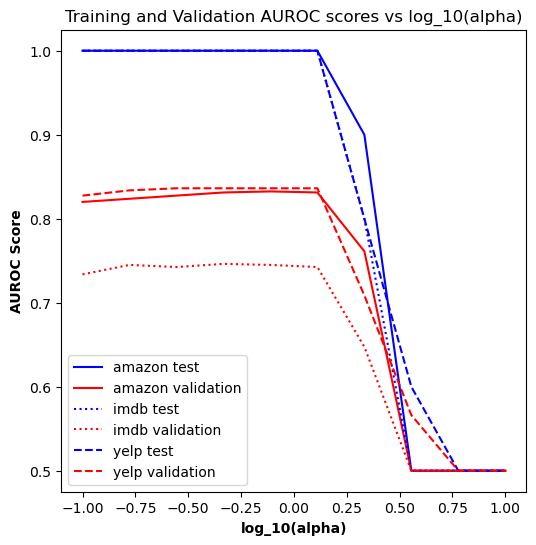

In [111]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot() 
ax.set_title("Training and Validation AUROC scores vs log_10(alpha)")

def add_classifier(axis, clf, linetype, label_pfx):
    # X is alpha values
    # Y is scores: either mean_test_score or mean_train_score
    x_axis = np.log10(np.asarray(clf.cv_results_["param_classifier__alpha"], dtype=np.float64))
    y_axis_1 = np.asarray(clf.cv_results_["mean_train_score"], dtype=np.float64)
    y_axis_2 = np.asarray(clf.cv_results_["mean_test_score"], dtype=np.float64)

    axis.plot(x_axis, y_axis_1, linetype, label=f"{label_pfx} test", color="blue")
    axis.plot(x_axis, y_axis_2, linetype, label=f"{label_pfx} validation", color="red")

add_classifier(ax, clf_amazon, "-", "amazon")
add_classifier(ax, clf_imdb, ":", "imdb")
add_classifier(ax, clf_yelp, "--", "yelp")

ax.set_xlabel("log_10(alpha)", fontweight="bold")
ax.set_ylabel("AUROC Score", fontweight="bold")
ax.legend(loc="lower left")


In [115]:
def print_incorrect_predictions(x, y, best_model, filename):
    x_train_example_fold, x_valid_example_fold, y_train_example_fold, y_valid_example_fold = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)

    best_model.fit(x_train_example_fold, y_train_example_fold)
    yhat_valid = best_model.predict_proba(x_valid_example_fold)[:,1]

    # now display the yhat_valid values next to the y_valid_example_fold values and the x_valid_example_fold values in a table:
    table = pd.DataFrame({
        'Predictions (yhat_valid)': yhat_valid,
        'True Labels (y_valid_example_fold)': y_valid_example_fold,
        'Input Examples (x_valid_example_fold)': x_valid_example_fold
    })

    table['Predictions (yhat_valid)'] = [0 if value < 0.5 else 1 for value in table['Predictions (yhat_valid)']]

    table['Correct'] = table['Predictions (yhat_valid)'] == table['True Labels (y_valid_example_fold)']

    # convert yhat predictions:

    # Map True/False to "correct"/"incorrect"
    table['Correct'] = table['Correct'].map({True: 'Correct', False: 'Incorrect'})

    table.to_csv(filename, index=False, sep="\t")

    incorrect_predictions = table[table['Correct'] == 'Incorrect']
    incorrect_ex = incorrect_predictions['Input Examples (x_valid_example_fold)']

    return incorrect_ex


In [124]:

print_incorrect_predictions(x_amazon, y_amazon, clf_amazon.best_estimator_, "yelp.tsv")


4      every thing on phone work perfectly, she like it.
5                 The shipping time was also very quick!
11     All I can do is whine on the Internet, so here...
17     I've bought $5 wired headphones that sound bet...
20                :-)Oh, the charger seems to work fine.
21     I find this inexcusable and so will probably b...
22     Appears to actually outperform the original ba...
23     It quit working after I'd used it for about 18...
28     The battery is working well as a replacement f...
39     A usable keyboard actually turns a PDA into a ...
45     I was very excited to get this headset because...
48                                        Lousy product.
59     They keep getting better and better (this is m...
76                                   Just what I wanted.
78     This is cool because most cases are just open ...
80     My phone sounded OK ( not great - OK), but my ...
85                                Exactly what I wanted.
101                            